In [1]:
%matplotlib inline
import glob
import matplotlib.pyplot as plt
import numpy as np

from os.path import join
from astropy.io import fits

from lsst.eotest.sensor import MaskedCCD
from ctisim import SegmentSimulator, LinearTrap, LogisticTrap, ITL_AMP_GEOM
from ctisim.core import BaseOutputAmplifier, FloatingOutputAmplifier

# Simulated Deferred Charge

Text(0.5, 0, 'Signal [e-]')

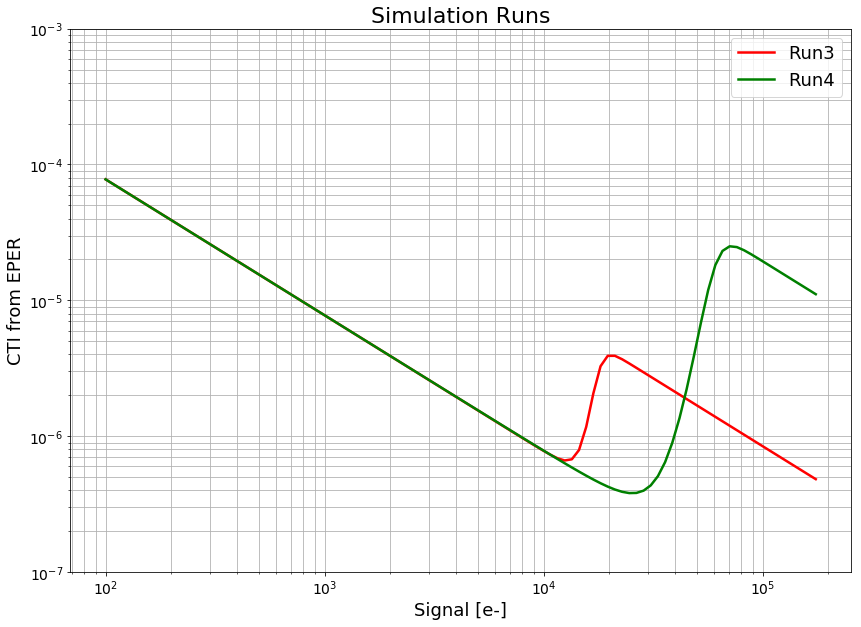

In [22]:
signals = np.logspace(2, np.log10(175000.), 100)
output_amplifier = BaseOutputAmplifier(1.0)

fig, ax = plt.subplots(1, 1, figsize=(14, 10))

## Run3
cti = 0.0
low_trap = LinearTrap(4.0, 0.4, 1, 0.08)
med_trap = LogisticTrap(40.0, 0.4, 1, 17500., 0.001)

imarr = np.zeros((signals.shape[0], ITL_AMP_GEOM.nx))
ramp = SegmentSimulator(imarr, ITL_AMP_GEOM.prescan_width, output_amplifier, 
                        cti=cti, traps=[low_trap, med_trap])
ramp.ramp_exp(signals)

segarr = ramp.readout(serial_overscan_width=ITL_AMP_GEOM.serial_overscan_width,
                               parallel_overscan_width=0)

last_pix = segarr[:, 511]
oscan1 = segarr[:, 512]
oscan2 = segarr[:, 513]
cti_run3 = ((oscan1+oscan2)/(511*last_pix))

## Run4
cti = 0.0
low_trap = LinearTrap(4.0, 0.4, 1, 0.08)
med_trap = LogisticTrap(1000.0, 0.4, 1, 60000., 0.0002)

imarr = np.zeros((signals.shape[0], ITL_AMP_GEOM.nx))
ramp = SegmentSimulator(imarr, ITL_AMP_GEOM.prescan_width, output_amplifier, 
                        cti=cti, traps=[low_trap, med_trap])
ramp.ramp_exp(signals)

segarr = ramp.readout(serial_overscan_width=ITL_AMP_GEOM.serial_overscan_width,
                               parallel_overscan_width=0)

last_pix = segarr[:, 511]
oscan1 = segarr[:, 512]
oscan2 = segarr[:, 513]
cti_run4 = ((oscan1+oscan2)/(511*last_pix))

ax.plot(signals, cti_run3, linewidth=2.5, color='red', label='Run3')
ax.plot(signals, cti_run4, linewidth=2.5, color='green', label='Run4')

ax.set_title('Simulation Runs', fontsize=22)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1.E-7, 1.E-3)
ax.legend(fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.grid(which='both')
ax.set_ylabel('CTI from EPER', fontsize=18)
ax.set_xlabel('Signal [e-]', fontsize=18)

# Flat Field Overscan Comparison

In [5]:
original_flats = sorted(glob.glob(join('/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/test/*processed.fits')))
corrected_flats = sorted(glob.glob(join('/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/test/*corrected.fits')))

Text(0.5, 0, 'Signal [e-]')

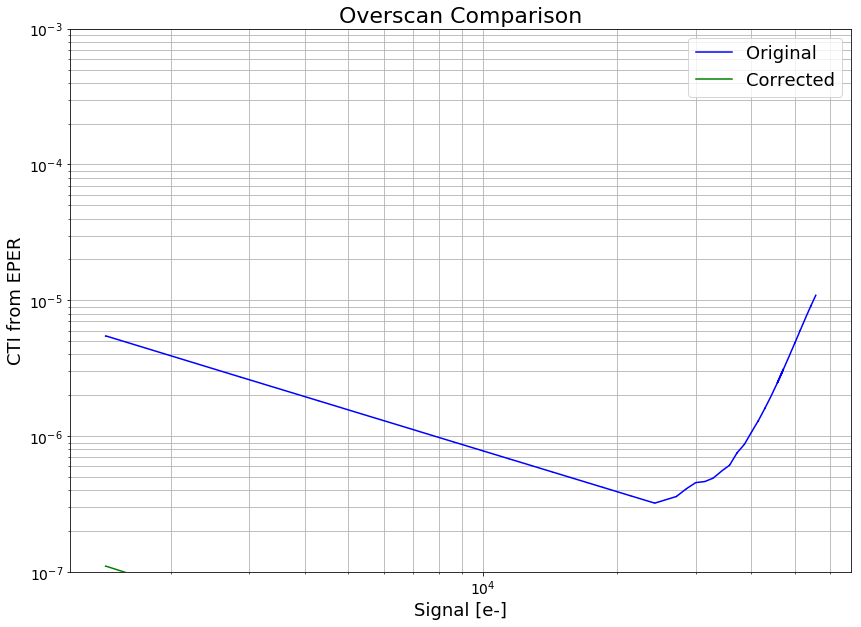

In [25]:
signals = np.zeros(len(original_flats))
cti_original = np.zeros(len(original_flats))
cti_corrected = np.zeros(len(original_flats))


amp = 7
for i, flat in enumerate(original_flats):
    
    with fits.open(flat) as hdulist:
        
        data = hdulist[amp].data
        last_pix = np.mean(data[:, 511])
        oscans = np.mean(np.sum(data[:, 512:514], axis=1))
        cti_original[i] = oscans/(511*last_pix)
        signals[i] = np.median(data[100:1900, 50:450])
        
for i, flat in enumerate(corrected_flats):
    
    with fits.open(flat) as hdulist:
        
        data = hdulist[amp].data
        last_pix = np.mean(data[:, 511])
        oscans = np.mean(np.sum(data[:, 512:514], axis=1))
        cti_corrected[i] = oscans/(511*last_pix)
        
fig, ax = plt.subplots(1, 1, figsize=(14, 10))
ax.plot(signals, cti_original, label='Original', color='blue')
ax.plot(signals, cti_corrected, label='Corrected', color='green')

ax.set_title('Overscan Comparison', fontsize=22)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1.E-7, 1.E-3)
ax.legend(fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.grid(which='both')
ax.set_ylabel('CTI from EPER', fontsize=18)
ax.set_xlabel('Signal [e-]', fontsize=18)

# Source Moment Comparison

In [7]:
main_dir = '/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/Sim/Originals/Spots'
original_catalogs = sorted(glob.glob(join('/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/Sim/Originals/Spots', 
                                          '*.cat')))
run3_catalogs = sorted(glob.glob(join('/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/Sim/Correction_Testing/Spots_Run3',
                                      'catalogs', '*.cat')))
run4_catalogs = sorted(glob.glob(join('/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/Sim/Correction_Testing/Spots_Run4',
                                      'catalogs', '*.cat')))


x_kwd = 'ext_shapeHSM_HsmSourceMoments_x'
y_kwd = 'ext_shapeHSM_HsmSourceMoments_y'
xx_kwd = 'ext_shapeHSM_HsmSourceMoments_xx'
yy_kwd = 'ext_shapeHSM_HsmSourceMoments_yy'
xy_kwd = 'ext_shapeHSM_HsmSourceMoments_xy'
flux_kwd = 'base_CircularApertureFlux_12_0_instFlux'

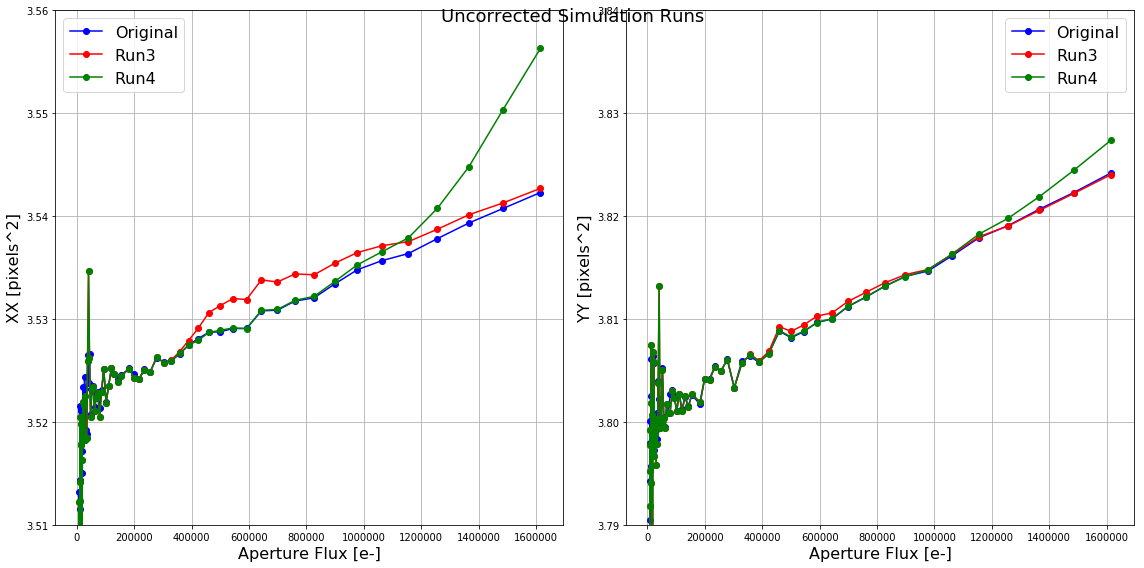

In [10]:
xx_results = []
yy_results = []
xy_results = []
flux_results = []

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

## Original Catalogs
for i, catalog in enumerate(original_catalogs):
    src = fits.getdata(catalog)
    
    if src[xx_kwd].shape[0] < 1200.:
        continue
    xx_results.append(np.nanmedian(src[xx_kwd]))
    yy_results.append(np.nanmedian(src[yy_kwd]))
    xy_results.append(np.nanmedian(src[xy_kwd]))
    flux_results.append(np.nanmedian(src[flux_kwd]))
im0 = axes[0].plot(flux_results, xx_results, c='blue', label='Original', marker='o')
im1 = axes[1].plot(flux_results, yy_results, c='blue', label='Original', marker='o')

## Run3 Catalogs
xx_results = []
yy_results = []
xy_results = []
flux_results = []
for i, catalog in enumerate(run3_catalogs):
    src = fits.getdata(catalog)
    
    if src[xx_kwd].shape[0] < 1200.:
        continue
    xx_results.append(np.nanmedian(src[xx_kwd]))
    yy_results.append(np.nanmedian(src[yy_kwd]))
    xy_results.append(np.nanmedian(src[xy_kwd]))
    flux_results.append(np.nanmedian(src[flux_kwd]))

im0 = axes[0].plot(flux_results, xx_results, c='red', label='Run3', marker='o')
im1 = axes[1].plot(flux_results, yy_results, c='red', label='Run3', marker='o')

## Run4 Catalogs
xx_results = []
yy_results = []
xy_results = []
flux_results = []
for i, catalog in enumerate(run4_catalogs):
    src = fits.getdata(catalog)
    
    if src[xx_kwd].shape[0] < 1200.:
        continue
    xx_results.append(np.nanmedian(src[xx_kwd]))
    yy_results.append(np.nanmedian(src[yy_kwd]))
    xy_results.append(np.nanmedian(src[xy_kwd]))
    flux_results.append(np.nanmedian(src[flux_kwd]))

im0 = axes[0].plot(flux_results, xx_results, c='green', label='Run4', marker='o')
im1 = axes[1].plot(flux_results, yy_results, c='green', label='Run4', marker='o')

#axes[0].set_xscale('log')
axes[0].set_ylabel('XX [pixels^2]', fontsize=16)
axes[0].set_xlabel('Aperture Flux [e-]', fontsize=16)
axes[0].set_ylim(bottom=3.51, top=3.56)
axes[0].legend(fontsize=16)
axes[0].grid(which='both')
#axes[1].set_xscale('log')
axes[1].set_ylabel('YY [pixels^2]', fontsize=16)
axes[1].set_xlabel('Aperture Flux [e-]', fontsize=16)
axes[1].set_ylim(bottom=3.79, top=3.84)
axes[1].grid(which='both')
axes[1].legend(fontsize=16)
fig.suptitle('Uncorrected Simulation Runs', fontsize=18)

plt.tight_layout()

In [6]:
run3_corrected_catalogs = sorted(glob.glob(join('/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/Sim/Correction_Testing/Spots_Run3_corrected',
                                      'catalogs', '*.cat')))
run4_corrected_catalogs = sorted(glob.glob(join('/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/Sim/Correction_Testing/Spots_Run4_corrected',
                                      'catalogs', '*.cat')))


x_kwd = 'ext_shapeHSM_HsmSourceMoments_x'
y_kwd = 'ext_shapeHSM_HsmSourceMoments_y'
xx_kwd = 'ext_shapeHSM_HsmSourceMoments_xx'
yy_kwd = 'ext_shapeHSM_HsmSourceMoments_yy'
xy_kwd = 'ext_shapeHSM_HsmSourceMoments_xy'
flux_kwd = 'base_CircularApertureFlux_12_0_instFlux'

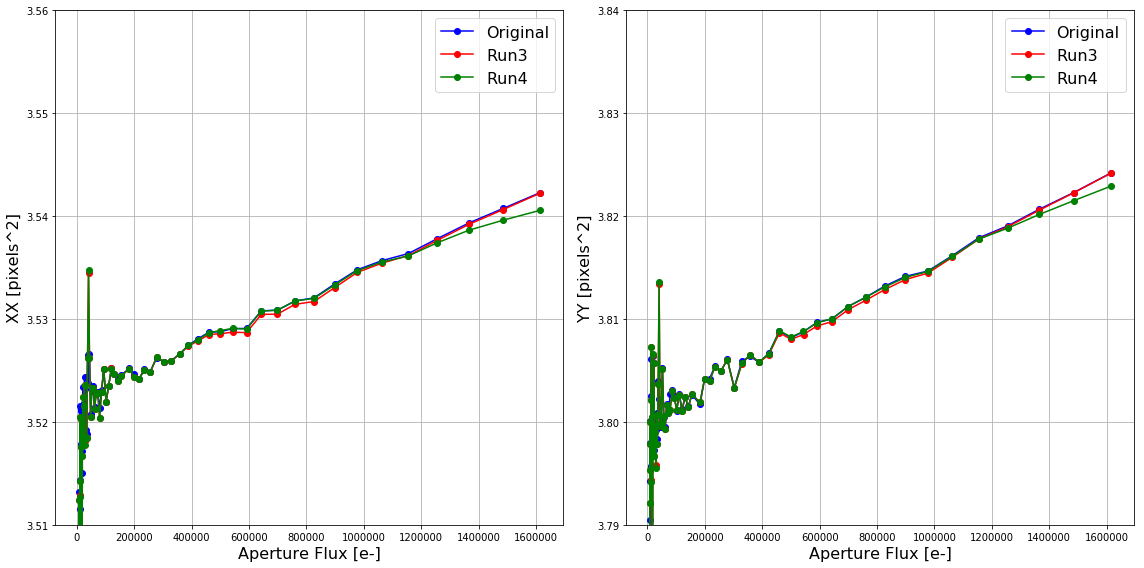

In [7]:
xx_results = []
yy_results = []
xy_results = []
flux_results = []

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

## Original Catalogs
for i, catalog in enumerate(original_catalogs):
    src = fits.getdata(catalog)
    
    if src[xx_kwd].shape[0] < 1200.:
        continue
    xx_results.append(np.nanmedian(src[xx_kwd]))
    yy_results.append(np.nanmedian(src[yy_kwd]))
    xy_results.append(np.nanmedian(src[xy_kwd]))
    flux_results.append(np.nanmedian(src[flux_kwd]))
im0 = axes[0].plot(flux_results, xx_results, c='blue', label='Original', marker='o')
im1 = axes[1].plot(flux_results, yy_results, c='blue', label='Original', marker='o')

## Run3 Catalogs
xx_results = []
yy_results = []
xy_results = []
flux_results = []
for i, catalog in enumerate(run3_corrected_catalogs):
    src = fits.getdata(catalog)
    
    if src[xx_kwd].shape[0] < 1200.:
        continue
    xx_results.append(np.nanmedian(src[xx_kwd]))
    yy_results.append(np.nanmedian(src[yy_kwd]))
    xy_results.append(np.nanmedian(src[xy_kwd]))
    flux_results.append(np.nanmedian(src[flux_kwd]))

im0 = axes[0].plot(flux_results, xx_results, c='red', label='Run3', marker='o')
im1 = axes[1].plot(flux_results, yy_results, c='red', label='Run3', marker='o')

## Run4 Catalogs
xx_results = []
yy_results = []
xy_results = []
flux_results = []
for i, catalog in enumerate(run4_corrected_catalogs):
    src = fits.getdata(catalog)
    
    if src[xx_kwd].shape[0] < 1200.:
        continue
    xx_results.append(np.nanmedian(src[xx_kwd]))
    yy_results.append(np.nanmedian(src[yy_kwd]))
    xy_results.append(np.nanmedian(src[xy_kwd]))
    flux_results.append(np.nanmedian(src[flux_kwd]))

im0 = axes[0].plot(flux_results, xx_results, c='green', label='Run4', marker='o')
im1 = axes[1].plot(flux_results, yy_results, c='green', label='Run4', marker='o')

#axes[0].set_xscale('log')
axes[0].set_ylabel('XX [pixels^2]', fontsize=16)
axes[0].set_xlabel('Aperture Flux [e-]', fontsize=16)
axes[0].set_ylim(bottom=3.51, top=3.56)
axes[0].legend(fontsize=16)
axes[0].grid(which='both')
#axes[1].set_xscale('log')
axes[1].set_ylabel('YY [pixels^2]', fontsize=16)
axes[1].set_xlabel('Aperture Flux [e-]', fontsize=16)
axes[1].set_ylim(bottom=3.79, top=3.84)
axes[1].grid(which='both')
axes[1].legend(fontsize=16)


plt.tight_layout()